# ОИАД. Лабораторная работа №4

Используйте набор данных datasets/famcs_students.csv

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную y = binary_cols[N % 8], где N - номер в списке группы. Остальные переменные используйте в качестве признаков X (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации y по признакам X.

Разделите случайно исходные данные на 3 выборки:

- тренировочная (70%) - для определения параметров модели
- валидацонная (15%) - для подбора гиперпараметров модели
- тестовую (15%) - итоговая оценка качества

In [58]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import math
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve

# Загрузка данных
df = pd.read_csv('famcs_students.csv')

# Определение целевой переменной (N=14, 14%8=6 -> study_form)
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']
target_col = binary_cols[6]  # study_form
print(f"Целевая переменная: {target_col}")

# Преобразование целевой переменной
binary_mapping = {'Нет': 0, 'Да': 1, 'Бюджет': 0, 'Платная': 1}
y = df[target_col].map(binary_mapping)

# Выбор признаков
selected_features = ['weekend_study', 'bad_sleep', 'work_experience', 'miss', 'score', 'retake']
X = df[selected_features].copy()

print("Выбранные признаки:")
print(selected_features)
print(f"\nРазмерность данных: {X.shape}")

# Преобразование категориальных признаков в числовой формат
# Бинарные признаки
binary_mapping = {'Нет': 0, 'Да': 1}
X['weekend_study'] = X['weekend_study'].map(binary_mapping)
X['bad_sleep'] = X['bad_sleep'].map(binary_mapping)

# work_experience: кодируем по возрастанию опыта
work_exp_mapping = {
    'Не работаю': 0,
    'Меньше года': 1, 
    '1-2 года': 2,
    'более 2 лет': 3
}
X['work_experience'] = X['work_experience'].map(work_exp_mapping)

# retake: преобразуем строковые значения в числовые
def convert_retake(value):
    if pd.isna(value):
        return 0
    elif str(value).strip() == '2+':
        return 3
    else:
        try:
            return float(value)
        except:
            return 0

X['retake'] = X['retake'].apply(convert_retake)

# Заполнение пропущенных значений
for col in X.columns:
    if X[col].dtype in [np.float64, np.int64]:
        X[col] = X[col].fillna(X[col].median())
    else:
        X[col] = X[col].fillna(X[col].mode()[0] if not X[col].mode().empty else 0)

print("Данные после преобразования:")
print(X.head())
print(f"\nПропущенные значения: {X.isnull().sum().sum()}")
print(f"Распределение целевой переменной: {Counter(y)}")

# Разделение на тренировочную, валидационную и тестовую выборки
def train_validate_test_split(X, y, train_size=0.7, validate_size=0.15, test_size=0.15, random_state=42):
    np.random.seed(random_state)
    
    n = len(X)
    indices = np.random.permutation(n)
    
    train_end = int(n * train_size)
    validate_end = train_end + int(n * validate_size)
    
    train_idx = indices[:train_end]
    validate_idx = indices[train_end:validate_end]
    test_idx = indices[validate_end:]
    
    return (X.iloc[train_idx], X.iloc[validate_idx], X.iloc[test_idx], 
            y.iloc[train_idx], y.iloc[validate_idx], y.iloc[test_idx])

X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(X, y)

print(f"\nТренировочная выборка: {X_train.shape[0]} samples")
print(f"Валидационная выборка: {X_val.shape[0]} samples") 
print(f"Тестовая выборка: {X_test.shape[0]} samples")
print(f"Распределение классов в тренировочной выборке: {Counter(y_train)}")

Целевая переменная: study_form
Выбранные признаки:
['weekend_study', 'bad_sleep', 'work_experience', 'miss', 'score', 'retake']

Размерность данных: (127, 6)
Данные после преобразования:
   weekend_study  bad_sleep  work_experience  miss  score  retake
0              1          1                1   3.0    9.2     0.0
1              0          0                2   5.0    8.8     0.0
2              1          0                1  10.0    8.8     0.0
3              1          1                2   3.0    8.8     0.0
4              1          0                0   1.0    9.0     0.0

Пропущенные значения: 0
Распределение целевой переменной: Counter({0: 94, 1: 33})

Тренировочная выборка: 88 samples
Валидационная выборка: 19 samples
Тестовая выборка: 20 samples
Распределение классов в тренировочной выборке: Counter({0: 63, 1: 25})


## 0. Тривиальный классификатор
Всегда выдает наиболее частый класс

In [59]:
# 0. Тривиальный классификатор
class TrivialClassifier:
    def __init__(self):
        self.most_common_class = None
    
    def fit(self, y):
        self.most_common_class = Counter(y).most_common(1)[0][0]
        print(f"Тривиальный классификатор: всегда предсказывает класс {self.most_common_class}")
    
    def predict(self, X):
        return np.array([self.most_common_class] * len(X))

# Обучение и предсказание
trivial_clf = TrivialClassifier()
trivial_clf.fit(y_train)
y_pred_trivial = trivial_clf.predict(X_test)

Тривиальный классификатор: всегда предсказывает класс 0


## 1. Наивный байесовский классификатор

In [60]:
# 1. Наивный байесовский классификатор
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.feature_stats = {}
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)
        
        # Вычисление априорных вероятностей
        for c in self.classes:
            self.class_priors[c] = np.sum(y == c) / n_samples
        
        # Вычисление статистик для каждого признака и класса
        self.feature_stats = {}
        for c in self.classes:
            class_data = X[y == c]
            self.feature_stats[c] = {
                'mean': class_data.mean(axis=0),
                'std': class_data.std(axis=0) + 1e-8
            }
    
    def _gaussian_pdf(self, x, mean, std):
        """Гауссовская функция плотности вероятности"""
        exponent = np.exp(-((x - mean) ** 2) / (2 * std ** 2))
        return (1 / (np.sqrt(2 * np.pi) * std)) * exponent
    
    def predict_proba(self, X):
        probabilities = []
        for _, sample in X.iterrows():
            class_probs = {}
            for c in self.classes:
                # Начинаем с априорной вероятности
                prob = np.log(self.class_priors[c])
                
                # Умножаем на вероятности признаков (в логарифмической шкале)
                for i, feature in enumerate(sample):
                    mean = self.feature_stats[c]['mean'].iloc[i]
                    std = self.feature_stats[c]['std'].iloc[i]
                    prob += np.log(self._gaussian_pdf(feature, mean, std))
                
                class_probs[c] = prob
            
            # Преобразование обратно из логарифмической шкалы
            max_log_prob = max(class_probs.values())
            for c in class_probs:
                class_probs[c] = np.exp(class_probs[c] - max_log_prob)
            
            # Нормализация
            total = sum(class_probs.values())
            for c in class_probs:
                class_probs[c] /= total
            
            probabilities.append([class_probs.get(0, 0), class_probs.get(1, 0)])
        
        return np.array(probabilities)
    
    def predict(self, X, threshold=0.5):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= threshold).astype(int)

# Обучение и предсказание
print("\nОбучение наивного байесовского классификатора...")
nb_clf = NaiveBayesClassifier()
nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)
y_pred_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

print(f"Априорные вероятности: {nb_clf.class_priors}")
print("Наивный байесовский классификатор успешно обучен!")


Обучение наивного байесовского классификатора...
Априорные вероятности: {0: 0.7159090909090909, 1: 0.2840909090909091}
Наивный байесовский классификатор успешно обучен!


## 2. Метод k-ближайших соседей
Реализовать алгоритм. Подобрать оптимальный гиперпараметр k.


Подбор оптимального k для KNN...
Оптимальное k: 1 с точностью 0.8947


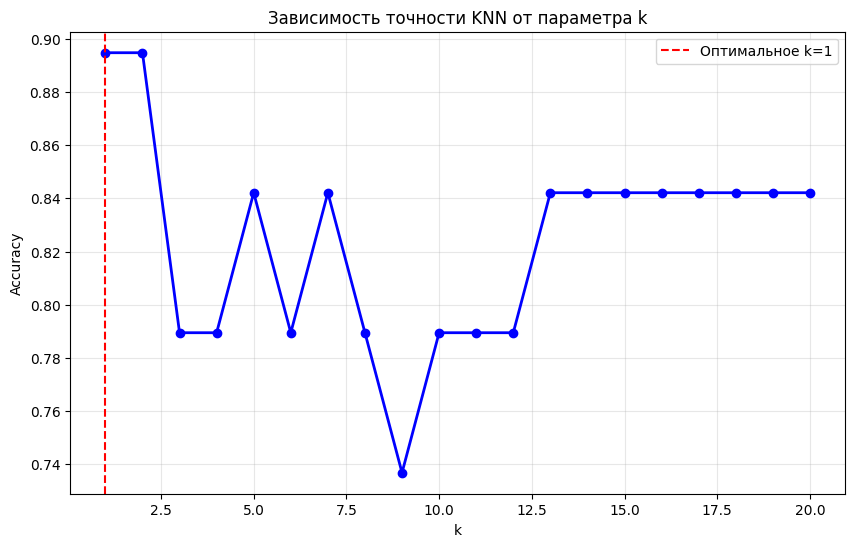

Обучение KNN с оптимальным k=1...
K-ближайших соседей успешно обучен!


In [61]:
# 2. Метод k-ближайших соседей
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k
    
    def fit(self, X, y):
        self.X_train = X.values
        self.y_train = y.values
    
    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def predict(self, X):
        predictions = []
        for _, sample in X.iterrows():
            distances = []
            for i, train_sample in enumerate(self.X_train):
                dist = self._euclidean_distance(sample.values, train_sample)
                distances.append((dist, self.y_train[i]))
            
            # Сортировка по расстоянию и выбор k ближайших
            distances.sort(key=lambda x: x[0])
            k_nearest = distances[:self.k]
            
            # Голосование большинством
            k_nearest_labels = [label for _, label in k_nearest]
            most_common = Counter(k_nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)
        
        return np.array(predictions)

# Подбор оптимального k на валидационной выборке
print("\nПодбор оптимального k для KNN...")
best_k = 1
best_accuracy = 0
k_accuracies = []

for k in range(1, 21):
    knn_clf = KNNClassifier(k=k)
    knn_clf.fit(X_train, y_train)
    y_pred_val = knn_clf.predict(X_val)
    accuracy = np.mean(y_pred_val == y_val)
    k_accuracies.append(accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_k = k

print(f"Оптимальное k: {best_k} с точностью {best_accuracy:.4f}")

# Визуализация зависимости точности от k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), k_accuracies, 'bo-', linewidth=2, markersize=6)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Оптимальное k={best_k}')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Зависимость точности KNN от параметра k')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Обучение с оптимальным k и предсказание на тестовой выборке
print(f"Обучение KNN с оптимальным k={best_k}...")
knn_clf = KNNClassifier(k=best_k)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)
y_pred_proba_knn = None  # KNN не возвращает вероятности
print("K-ближайших соседей успешно обучен!")

## 3. Логистическая регрессия
Алгоритм реализуйте сами! Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

Обучение логистической регрессии с балансировкой классов...
Итерация 0, Cost: 0.6933
Итерация 500, Cost: 0.6382
Итерация 1000, Cost: 0.6382
Итерация 1500, Cost: 0.6382
Итерация 2000, Cost: 0.6382
Итерация 2500, Cost: 0.6382


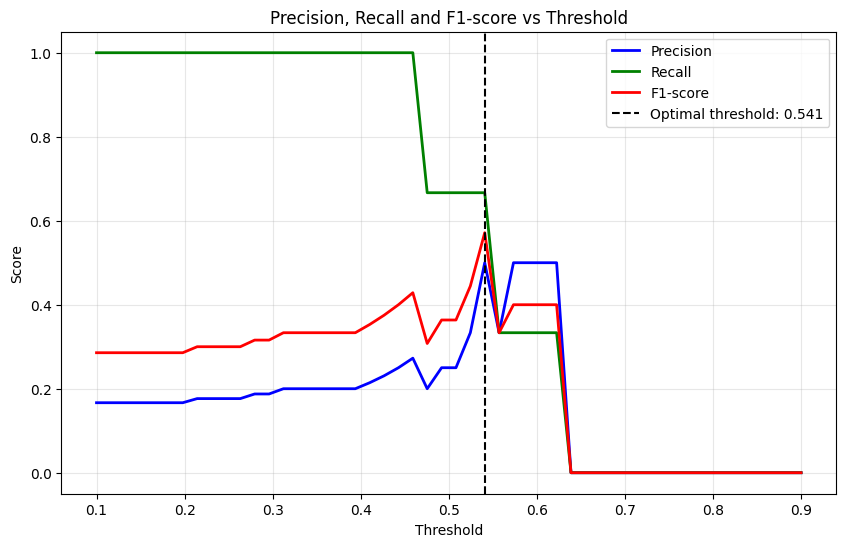

Оптимальный порог: 0.541
Логистическая регрессия успешно обучена!


In [64]:
# 3. Логистическая регрессия с балансировкой классов
class RobustLogisticRegression:
    def __init__(self, learning_rate=0.05, n_iter=3000, class_weight=None):
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.class_weight = class_weight
    
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -10, 10)))
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Балансировка классов
        if self.class_weight == 'balanced':
            class_counts = np.bincount(y)
            n_classes = len(class_counts)
            self.class_weights = n_samples / (n_classes * class_counts)
        else:
            self.class_weights = np.ones(len(np.unique(y)))
        
        # Стандартизация
        self.X_mean = X.mean(axis=0)
        self.X_std = X.std(axis=0) + 1e-8
        X_scaled = (X - self.X_mean) / self.X_std
        
        # Инициализация с учетом баланса
        self.weights = np.random.normal(0, 0.01, n_features)
        self.bias = 0
        
        print("Обучение логистической регрессии с балансировкой классов...")
        for iteration in range(self.n_iter):
            z = np.dot(X_scaled, self.weights) + self.bias
            predictions = self._sigmoid(z)
            
            # Взвешенные градиенты
            weights_array = np.array([self.class_weights[label] for label in y])
            dw = np.dot(X_scaled.T, weights_array * (predictions - y)) / n_samples
            db = np.mean(weights_array * (predictions - y))
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if iteration % 500 == 0:
                cost = -np.mean(weights_array * (y * np.log(predictions + 1e-8) + 
                                              (1 - y) * np.log(1 - predictions + 1e-8)))
                print(f"Итерация {iteration}, Cost: {cost:.4f}")
    
    def predict_proba(self, X):
        X_scaled = (X - self.X_mean) / self.X_std
        z = np.dot(X_scaled, self.weights) + self.bias
        return self._sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Обучение модели с балансировкой
robust_lr = RobustLogisticRegression(learning_rate=0.05, n_iter=3000, class_weight='balanced')
robust_lr.fit(X_train.values, y_train.values)

# Подбор оптимального порога
def calculate_metrics(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Поиск оптимального порога
y_val_proba = robust_lr.predict_proba(X_val.values)
thresholds = np.linspace(0.1, 0.9, 50)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_val = (y_val_proba >= threshold).astype(int)
    precision, recall, f1 = calculate_metrics(y_val.values, y_pred_val)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Выбор порога с максимальным F1
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
plt.plot(thresholds, recalls, 'g-', label='Recall', linewidth=2)
plt.plot(thresholds, f1_scores, 'r-', label='F1-score', linewidth=2)
plt.axvline(x=best_threshold, color='k', linestyle='--', label=f'Optimal threshold: {best_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall and F1-score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Оптимальный порог: {best_threshold:.3f}")

# Предсказание на тестовой выборке с оптимальным порогом
y_pred_lr = robust_lr.predict(X_test.values, threshold=0.541)  
y_pred_proba_lr = robust_lr.predict_proba(X_test.values)
print("Логистическая регрессия успешно обучена!")


## 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:
- accuracy
- precision
- recall
- roc-auc
- постройте матрицу ошибок

ПОЛНАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ

МОДЕЛЬ: Тривиальный классификатор


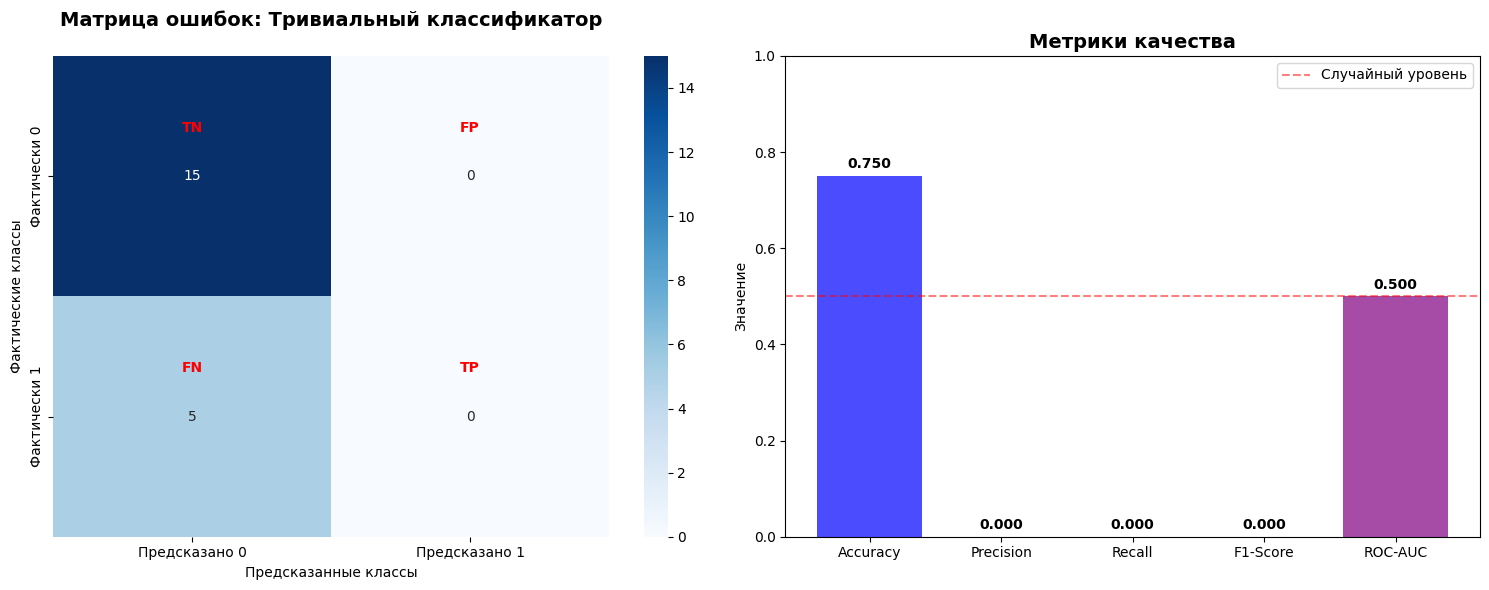


Тривиальный классификатор:
Матрица ошибок:
  TN: 15 | FP:  0
  FN:  5 | TP:  0
Accuracy:  0.7500
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.5000

МОДЕЛЬ: Наивный Байес


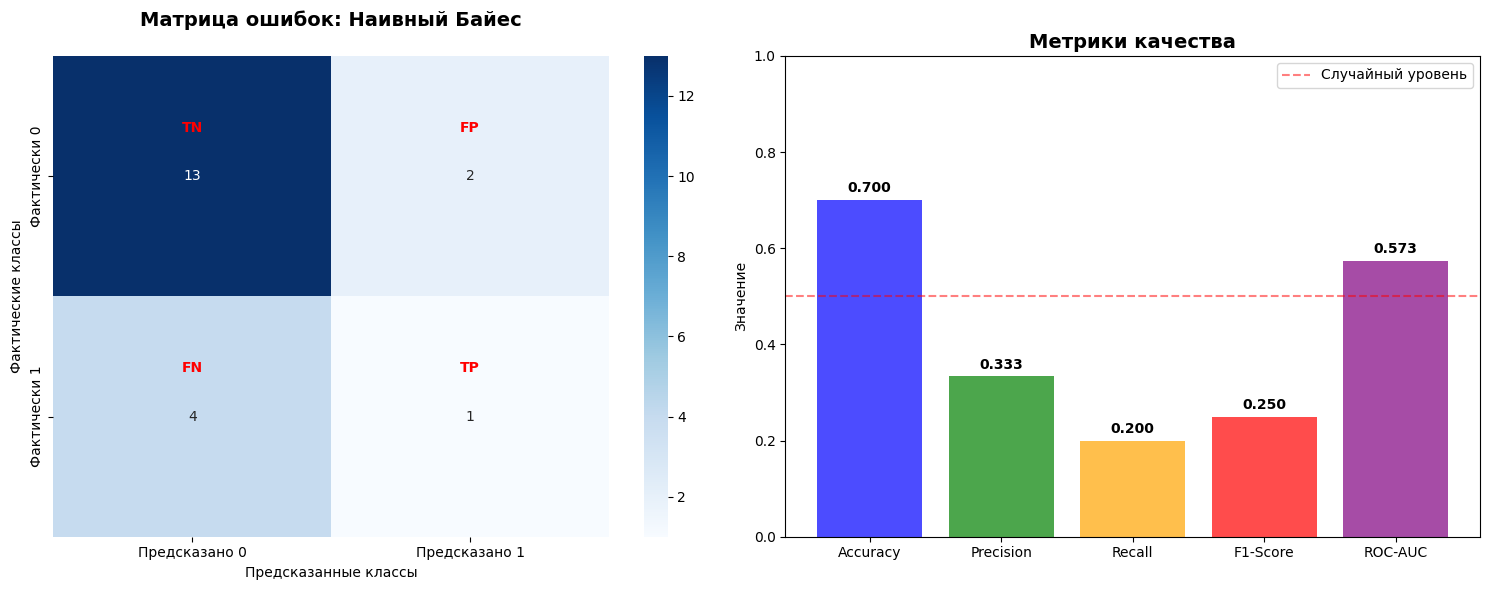


Наивный Байес:
Матрица ошибок:
  TN: 13 | FP:  2
  FN:  4 | TP:  1
Accuracy:  0.7000
Precision: 0.3333
Recall:    0.2000
F1-score:  0.2500
ROC-AUC:   0.5733

МОДЕЛЬ: K-ближайших соседей


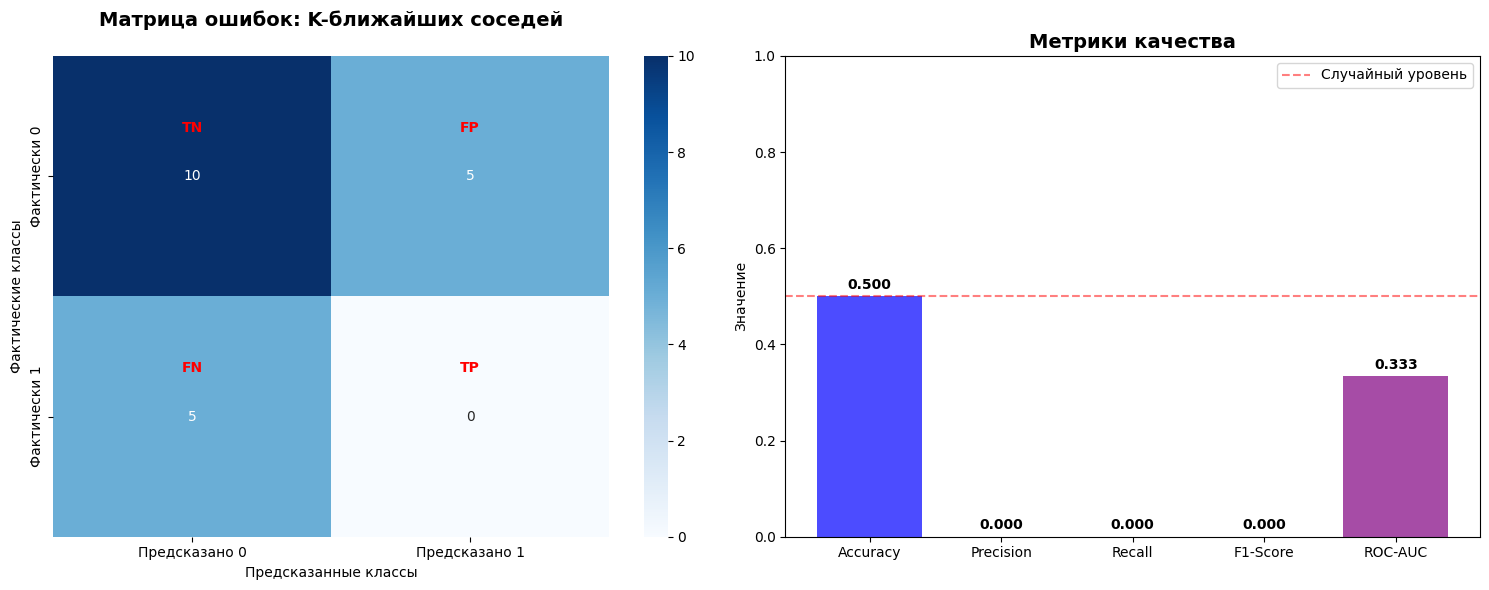


K-ближайших соседей:
Матрица ошибок:
  TN: 10 | FP:  5
  FN:  5 | TP:  0
Accuracy:  0.5000
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.3333

МОДЕЛЬ: Логистическая регрессия


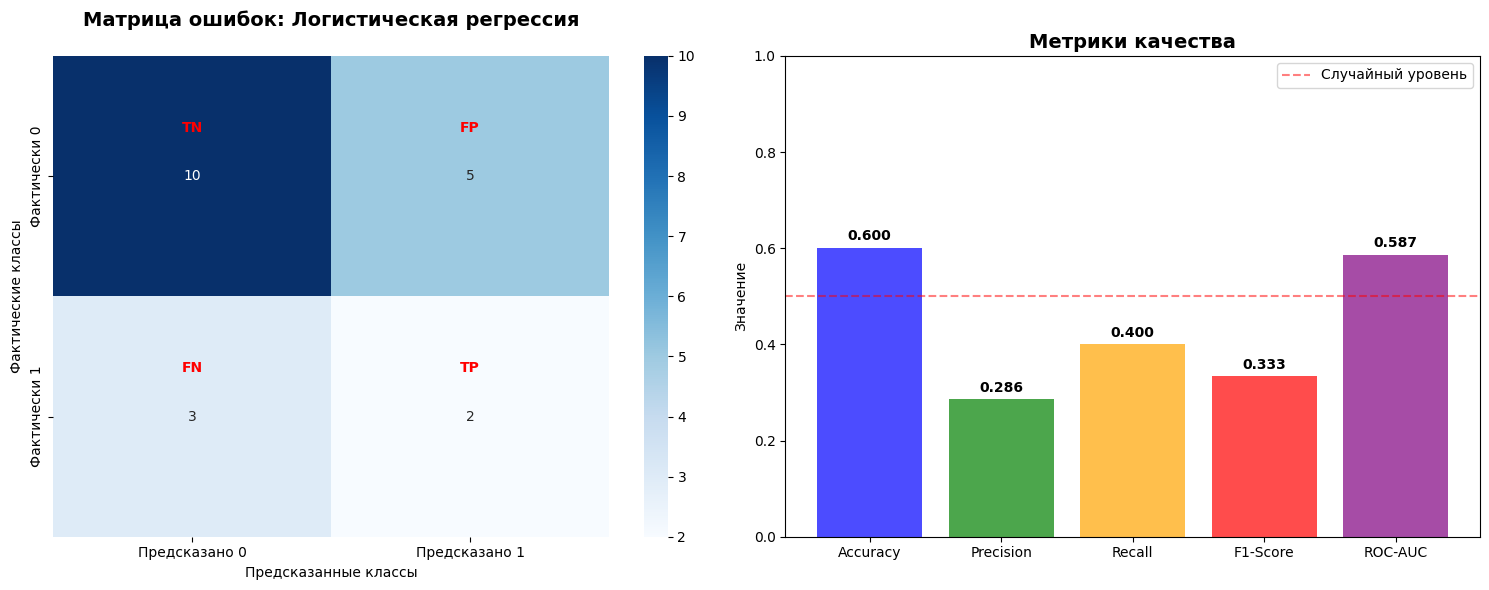


Логистическая регрессия:
Матрица ошибок:
  TN: 10 | FP:  5
  FN:  3 | TP:  2
Accuracy:  0.6000
Precision: 0.2857
Recall:    0.4000
F1-score:  0.3333
ROC-AUC:   0.5867

СРАВНИТЕЛЬНАЯ ТАБЛИЦА ВСЕХ МОДЕЛЕЙ


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Тривиальный классификатор,0.7500,0.0000,0.0000,0.0000,0.5000
Наивный Байес,0.7000,0.3333,0.2000,0.2500,0.5733
K-ближайших соседей,0.5000,0.0000,0.0000,0.0000,0.3333
Логистическая регрессия,0.6000,0.2857,0.4000,0.3333,0.5867


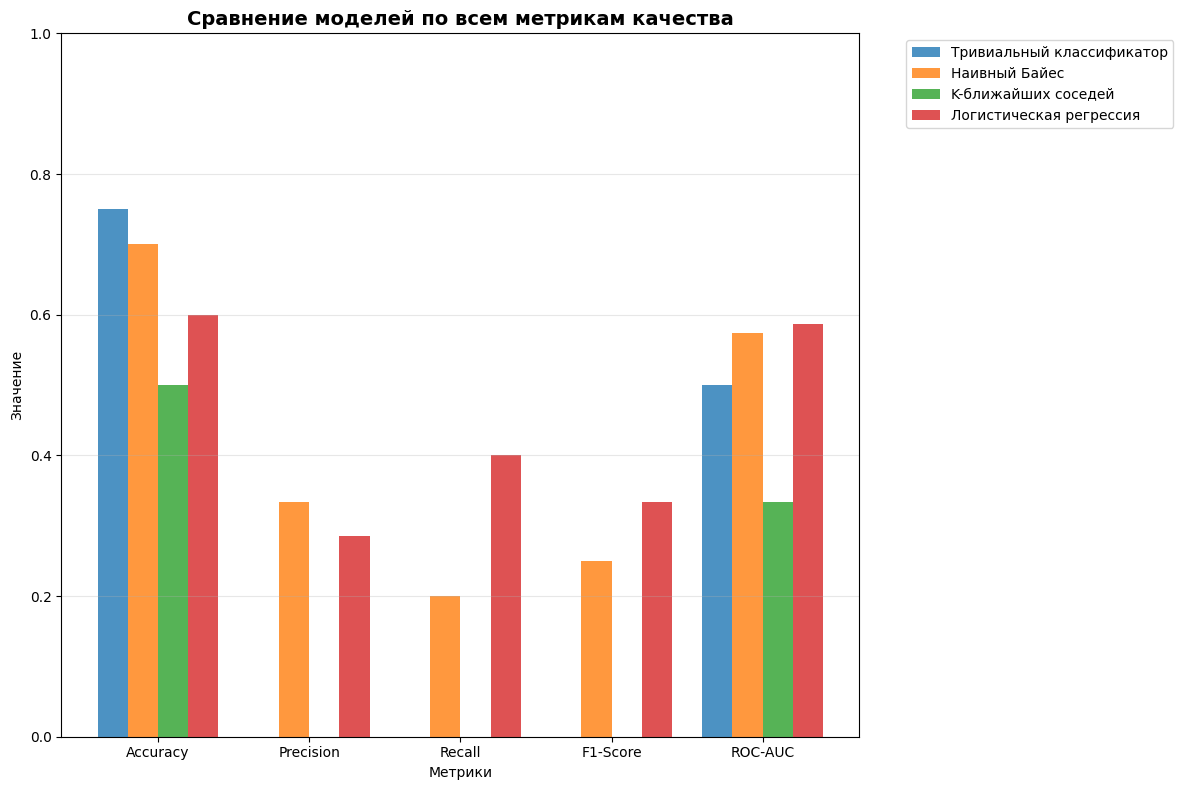

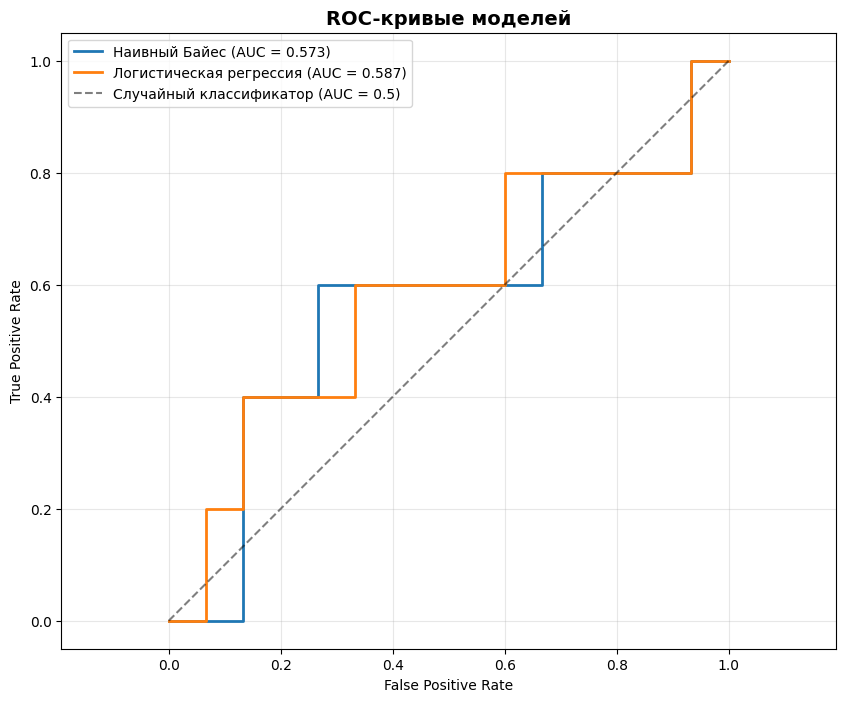

ЛУЧШАЯ МОДЕЛЬ: Логистическая регрессия
F1-Score: 0.3333


In [68]:
# 4. Оценка качества всех моделей с визуализацией матрицы ошибок
def evaluate_model_with_plot(y_true, y_pred, y_pred_proba, model_name):
    # Вычисляем метрики
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # ROC-AUC (если есть вероятности)
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_pred_proba)
        except:
            roc_auc = (1 + recall - (np.sum((y_true == 0) & (y_pred == 1)) / np.sum(y_true == 0))) / 2
    else:
        roc_auc = (1 + recall - (np.sum((y_true == 0) & (y_pred == 1)) / np.sum(y_true == 0))) / 2
    
    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    
    # Создаем график
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # График 1: Матрица ошибок
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Предсказано 0', 'Предсказано 1'],
                yticklabels=['Фактически 0', 'Фактически 1'])
    ax1.set_title(f'Матрица ошибок: {model_name}\n', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Предсказанные классы')
    ax1.set_ylabel('Фактические классы')
    
    # Добавляем описания к ячейкам матрицы
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == 0 and j == 0:
                ax1.text(j+0.5, i+0.3, 'TN', ha='center', va='center', fontweight='bold', color='red')
            elif i == 0 and j == 1:
                ax1.text(j+0.5, i+0.3, 'FP', ha='center', va='center', fontweight='bold', color='red')
            elif i == 1 and j == 0:
                ax1.text(j+0.5, i+0.3, 'FN', ha='center', va='center', fontweight='bold', color='red')
            elif i == 1 and j == 1:
                ax1.text(j+0.5, i+0.3, 'TP', ha='center', va='center', fontweight='bold', color='red')
    
    # График 2: Метрики качества
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    values = [accuracy, precision, recall, f1, roc_auc]
    colors = ['blue', 'green', 'orange', 'red', 'purple']
    
    bars = ax2.bar(metrics, values, color=colors, alpha=0.7)
    ax2.set_title('Метрики качества', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Значение')
    ax2.set_ylim(0, 1)
    
    # Добавляем значения на столбцы
    for bar, value in zip(bars, values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Добавляем горизонтальную линию для случайного классификатора
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Случайный уровень')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Выводим числовые значения
    print(f"\n{model_name}:")
    print(f"Матрица ошибок:")
    print(f"  TN: {cm[0,0]:2d} | FP: {cm[0,1]:2d}")
    print(f"  FN: {cm[1,0]:2d} | TP: {cm[1,1]:2d}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    return accuracy, precision, recall, f1, roc_auc

# Оценка всех моделей с визуализацией
print("ПОЛНАЯ ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ")

# Для тривиального классификатора вероятностей нет
y_pred_proba_trivial = None

models_with_proba = {
    'Тривиальный классификатор': (y_pred_trivial, y_pred_proba_trivial),
    'Наивный Байес': (y_pred_nb, y_pred_proba_nb),
    'K-ближайших соседей': (y_pred_knn, y_pred_proba_knn),
    'Логистическая регрессия': (y_pred_lr, y_pred_proba_lr)
}

results = {}
for name, (y_pred, y_proba) in models_with_proba.items():
    print(f"\nМОДЕЛЬ: {name}")
    results[name] = evaluate_model_with_plot(y_test.values, y_pred, y_proba, name)

# Сравнительная таблица всех моделей
print("\nСРАВНИТЕЛЬНАЯ ТАБЛИЦА ВСЕХ МОДЕЛЕЙ")

comparison_df = pd.DataFrame(results).T
comparison_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
comparison_df = comparison_df.round(4)

# Добавляем цветовое форматирование
styled_df = comparison_df.style.background_gradient(cmap='RdYlGn', axis=0, vmin=0, vmax=1)\
                              .format("{:.4f}")\
                              .set_caption("Сравнение моделей по всем метрикам (зеленый = лучше)")

display(styled_df)

# Визуализация сравнения моделей
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x_pos = np.arange(len(metrics))
width = 0.2

for i, (model, scores) in enumerate(results.items()):
    plt.bar(x_pos + i*width, scores, width, label=model, alpha=0.8)

plt.xlabel('Метрики')
plt.ylabel('Значение')
plt.title('Сравнение моделей по всем метрикам качества', fontsize=14, fontweight='bold')
plt.xticks(x_pos + width*1.5, metrics)
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ROC-кривые для моделей с вероятностями
plt.figure(figsize=(10, 8))

models_with_roc = {
    'Наивный Байес': y_pred_proba_nb,
    'Логистическая регрессия': y_pred_proba_lr
}

for name, y_proba in models_with_roc.items():
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test.values, y_proba)
        roc_auc = roc_auc_score(y_test.values, y_proba)
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Диагональ случайного классификатора
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Случайный классификатор (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

# Находим лучшую модель по F1-score
best_model_name = max(results.items(), key=lambda x: x[1][3])[0]
best_f1 = results[best_model_name][3]

print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"F1-Score: {best_f1:.4f}")
